In [15]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputMastersFolder = inputFolder + r"\masters"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

In [17]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        #print(str(soup))
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          emailAttendeesText = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          emailAttendeesList = emailAttendeesText.split("; ")
          for emailAttendee in emailAttendeesList:
            if emailAttendee not in attendees:
              attendees.append(emailAttendee)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

def readSupport(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

In [18]:
def readAndWritePreprocessedData(preprocessedData, masters):
  ## Decisiones propias para el modelo
  # Transformar la data a dataframe
  df = pd.DataFrame(preprocessedData)

  for i in range(0, len(masters)):
    masters[i] = pd.DataFrame(masters[i])

  # Eliminar los campos que ya no se usarán
  columnsToDelete = [
    "candidatePostulationDate", "jobId", "candidateFullName", "candidateDocumentNumber", "candidateBirthDate", "candidateAddress", "candidateHomeNumber", "candidateCellphoneNumber", "candidateEmail", "workObjetive", "lastWorkDays", "lastWorkDescription", "lastEducationDays"
  ]
  df = df.drop(columns=columnsToDelete)

  # Aplicar las equivalencias a los campos: jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName
  equivalences = ["jobProfileName", "lastWorkCompany", "lastWorkArea", "lastWorkName", "lastEducationCompany", "lastEducationArea", "lastEducationName"]

  # Mejorar las equivalencias poco a poco
  for index, equivalence in enumerate(equivalences):
    df = pd.merge(df, masters[index], on=equivalence)
    df[equivalence] = df["equivalence"]
    df = df.drop(columns=["equivalence", "count", "equals"])
    
  print(len(df))
  
  ## Decisiones por la metodología

  # Analisis de valores nulos
  """
  # Reemplazando las cadenas vacias a nulos
  df = df.replace(r'^\s*$', None, regex=True)

  # Eliminando columnas con al menos un nulo
  #df = df.dropna()

  # Obteniendo el porcentaje de nulos por columna
  percentMissing = df.isnull().sum() * 100 / len(df)
  missingValueDf = pd.DataFrame({'columnName': df.columns, 'percentMissing': percentMissing })
  missingValueDf = missingValueDf.sort_values('percentMissing', ascending=False)
  """
  
  # Al ninguno superar el 30% de nulos, no se eliminará ninguna columna

  # Regresando el dataframe a array de dicts
  preprocessedData = df.to_dict('records')

  writeJson(preprocessedData, os.path.join(outputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(outputFolder, 'result.csv'), 'utf-8')

  writeJson(preprocessedData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return preprocessedData

In [19]:
def visualizeData(preprocessedData):
  df = pd.DataFrame(preprocessedData)

  print(df.count())

  columns = [elem for elem in df.columns]

  for column in columns:
    topDf = df[column].value_counts()[:dataVisualizationTopLimit]
    print(topDf)
    y_axis = list(reversed(topDf.index))
    x_axis = list(reversed(topDf.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

In [20]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # Leyendo la data obtenida en el entendimiento de los datos
  bumeranData = readJson(os.path.join(inputMainFolder, 'result.json'))
  # Leyendo archivos maestros
  jobProfileName = readSupport(os.path.join(inputMastersFolder, 'jobProfileName.csv'))
  lastWorkCompany = readSupport(os.path.join(inputMastersFolder, 'lastWorkCompany.csv'))
  lastWorkArea = readSupport(os.path.join(inputMastersFolder, 'lastWorkArea.csv'))
  lastWorkName = readSupport(os.path.join(inputMastersFolder, 'lastWorkName.csv'))
  lastEducationCompany = readSupport(os.path.join(inputMastersFolder, 'lastEducationCompany.csv'))
  lastEducationArea = readSupport(os.path.join(inputMastersFolder, 'lastEducationArea.csv'))
  lastEducationName = readSupport(os.path.join(inputMastersFolder, 'lastEducationName.csv'))

  isPreprocessed = False

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(outputFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(bumeranData, [jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-22 00:42:53.331672
Se inició el procesamiento
10225
Se terminó el preprocesamiento
jobProfileName               10225
candidateResidenceCountry    10225
candidateCivilStatus         10225
candidateBirthCountry        10225
salary                       10225
lastWorkCompany              10225
lastWorkCountry              10225
lastWorkArea                 10225
lastWorkName                 10225
yearsOfExperience            10225
worksNumber                  10225
lastEducationCompany         10225
lastEducationCountry         10225
lastEducationArea            10225
lastEducationName            10225
lastEducationStatus          10225
lastEducationDegree          10225
yearsOfStudy                 10225
studiesNumber                10225
technicalSkills              10225
languages                    10225
otherSkills                  10225
hired                        10225
dtype: int64
Ejecutivo Comercial                      1213
Practicante De Recursos Humanos      

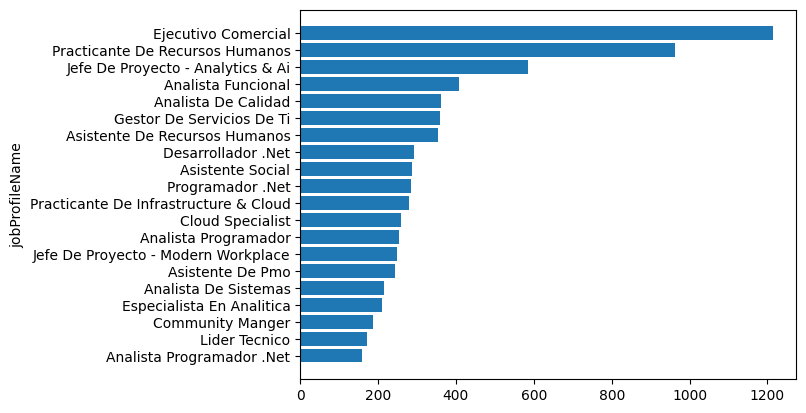

Peru                    9980
Venezuela                145
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Chile                      2
Republica Dominicana       2
Espana                     1
Panama                     1
Bolivia                    1
El Salvador                1
Costa Rica                 1
Francia                    1
Name: candidateResidenceCountry, dtype: int64


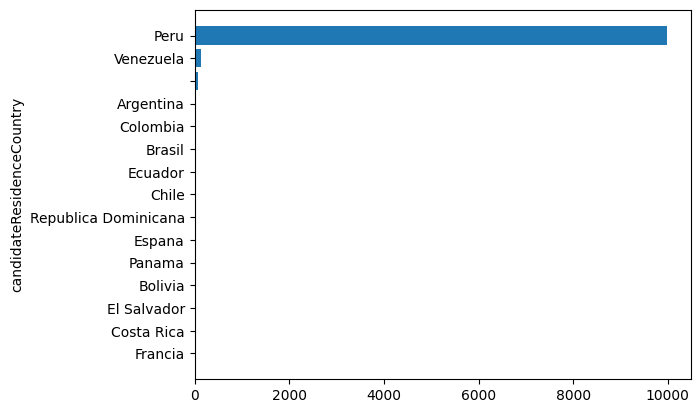

Soltero/A          7832
Casado/A           1487
                    623
Divorciado/A        126
Pareja De Hecho     108
Union Libre          46
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


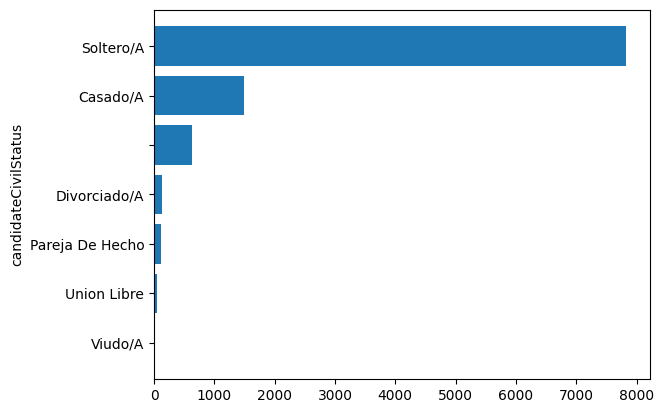

Peru                    9980
Venezuela                145
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Chile                      2
Republica Dominicana       2
Espana                     1
Panama                     1
Bolivia                    1
El Salvador                1
Costa Rica                 1
Francia                    1
Name: candidateBirthCountry, dtype: int64


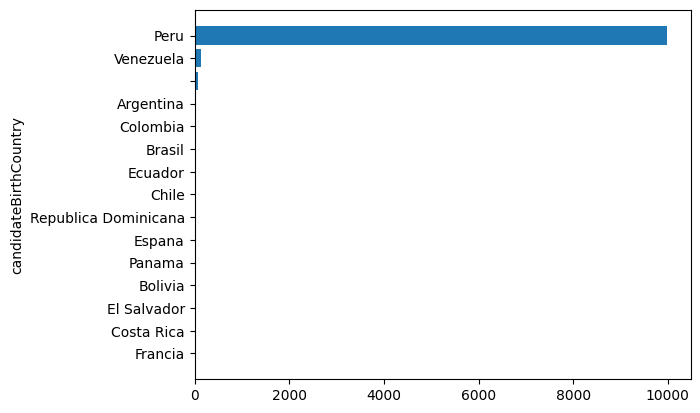

2500    617
5000    617
2000    588
3500    562
3000    549
4000    532
1500    472
6000    438
0       424
4500    405
1200    362
1800    354
5500    302
1025    298
7000    283
1000    282
6500    281
930     227
8000    202
1       201
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


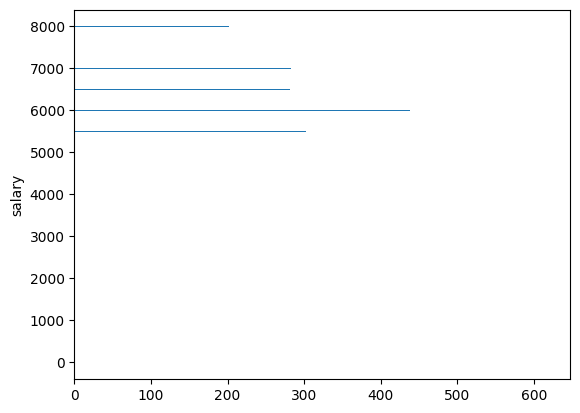

                                                   570
Freelance                                          199
Ntt Data Peru S.A.C.                               169
Canvia S.A.C.                                      152
Mdp Consulting S.A.C.                              111
Global Hitss Peru S.A.C.                           109
Manpower Professional Services S.A.                106
Telefonica Del Peru                                 83
Indra Peru S.A.                                     83
Banco De Credito Del Peru - Bcp                     81
Stefanini It Solutions                              71
Tata Consultancy Services                           54
Corporacion Sapia S.A.                              53
Universidad Peruana De Ciencias Aplicadas (Upc)     43
Tgestiona Sac                                       40
Ferreyros S.A.                                      39
Oficina Nacional De Procesos Electorales (Onpe)     37
Gfi Peru Sac                                        37
America Mo

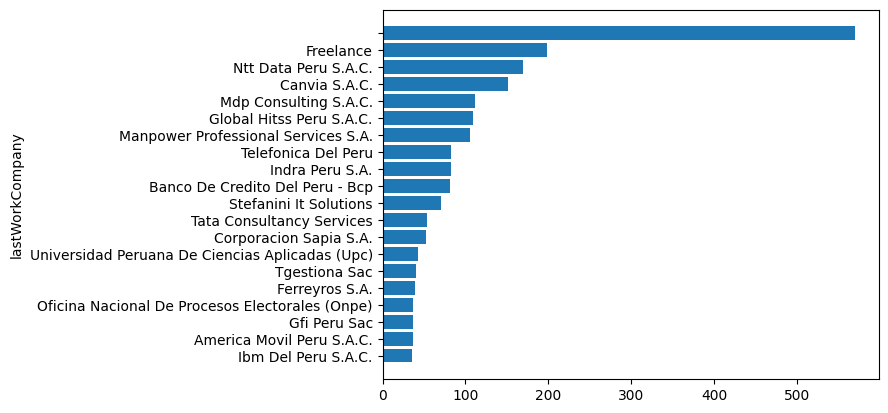

Peru              9488
                   562
Estados Unidos      31
Venezuela           25
Espana              23
Colombia            17
Brasil              16
Chile               12
Argentina            7
Ecuador              7
Mexico               4
Costa Rica           3
Reino Unido          3
Albania              3
Panama               2
Francia              2
Italia               2
Paises Bajos         2
Finlandia            2
Australia            2
Name: lastWorkCountry, dtype: int64


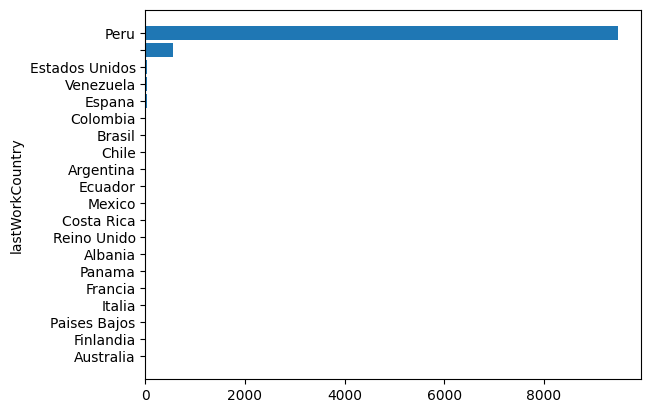

Tecnologia / Sistemas            1047
Tecnologias De La Informacion    1027
Programacion                      590
Liderazgo De Proyecto             587
                                  562
Comercial                         553
Sistemas                          489
Recursos Humanos                  438
Ventas                            267
Administracion                    258
Analisis De Datos                 237
Analisis Funcional                221
Infraestructura                   216
Soporte Tecnico                   202
Atencion Al Cliente               164
Seguridad Informatica             156
Otras Ingenierias                 151
Desarrollo De Negocios            132
Testing / Qa / Qc                 128
Telecomunicaciones                119
Name: lastWorkArea, dtype: int64


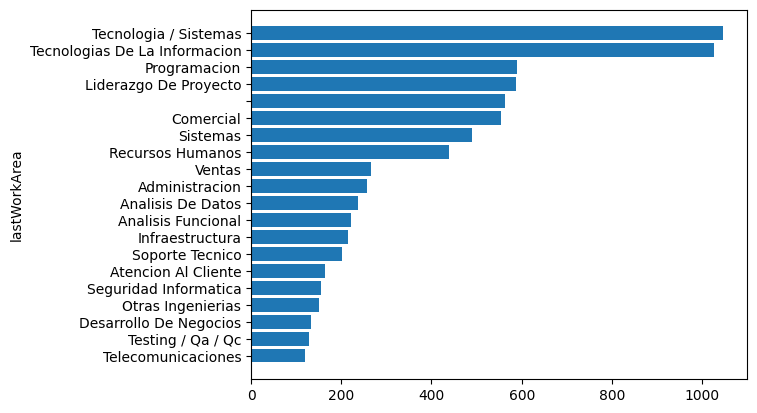

                                                562
Analista Programador                            537
Analista De Sistemas                            258
Jefe De Proyectos                               171
Analista Funcional                              154
Asistente Administrativo                        104
Analista De Calidad                              98
Trabajadora Social                               98
Ejecutivo Comercial                              91
Asistente De Recursos Humanos                    87
Supervisor De Infraestructura De Redes Cisco     84
Project Manager                                  69
Asesor Comercial                                 65
Lider Tecnico                                    61
Gerente De Proyectos                             58
Soporte Tecnico                                  56
Practicante De Recursos Humanos                  51
Practicante                                      51
Analista                                         50
Analista Des

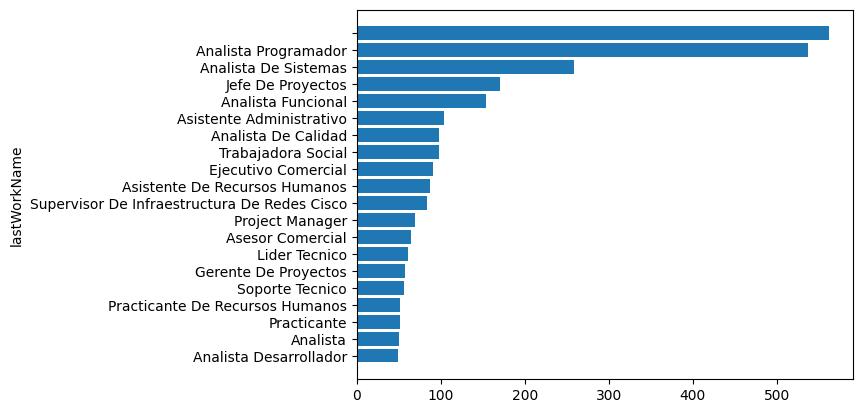

0     1162
4      736
5      698
8      678
7      665
6      654
2      651
1      643
3      619
9      537
10     505
11     426
12     310
13     308
15     258
14     249
16     179
17     128
20     111
19     110
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


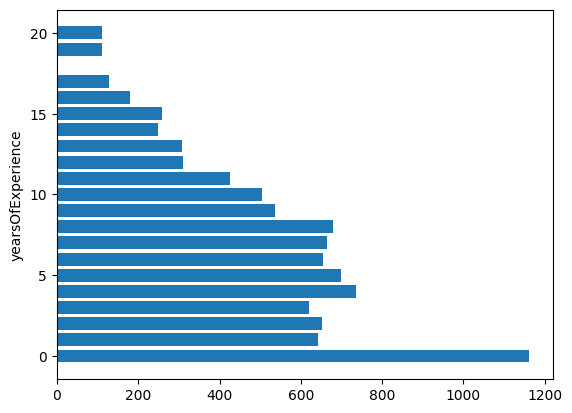

5     1300
4     1184
6     1059
3     1021
7      935
2      740
8      735
1      663
0      562
9      530
10     407
11     274
12     238
13     152
14     119
15      91
17      60
16      45
19      37
18      30
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


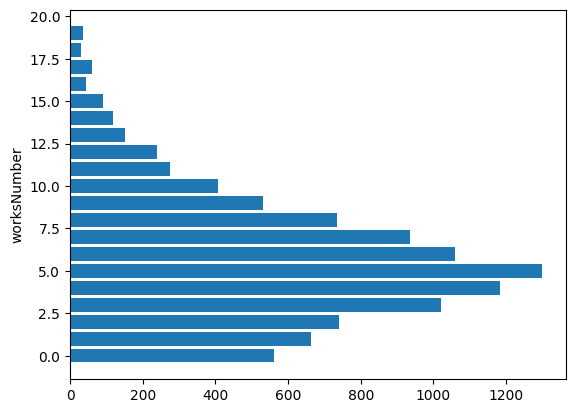

Universidad Peruana De Ciencias Aplicadas    906
Universidad Tecnologica Del Peru             514
Instituto Cibertec                           432
Pontificia Universidad Catolica Del Peru     344
Universidad Privada Del Norte                340
Universidad San Ignacio Del Loyola           325
Universidad Nacional Mayor De San Marcos     323
Universidad Cesar Vallejo                    291
Universidad Esan                             282
Universidad De Lima                          243
Universidad De San Martin De Porres          213
Universidad Nacional De Ingenieria           212
Universidad Ricardo Palma                    186
Universidad Nacional Federico Villarreal     185
Instituto San Ignacio De Loyola              184
                                             183
Universidad Inca Garcilaso De La Vega        175
Tecsup                                       123
Instituto Superior Tecnologico Idat          116
Universidad Del Pacifico                     106
Name: lastEducationC

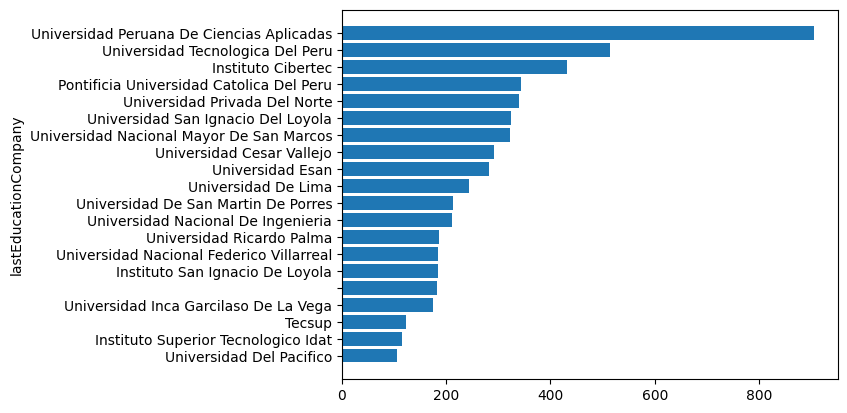

Peru              9488
Espana             197
Venezuela          162
                   123
Estados Unidos      78
Mexico              34
Argentina           20
Colombia            19
Brasil              19
Chile               18
Costa Rica          14
Canada               8
Bolivia              6
Ecuador              6
Australia            6
Francia              5
India                3
Alemania             3
Reino Unido          3
Cuba                 2
Name: lastEducationCountry, dtype: int64


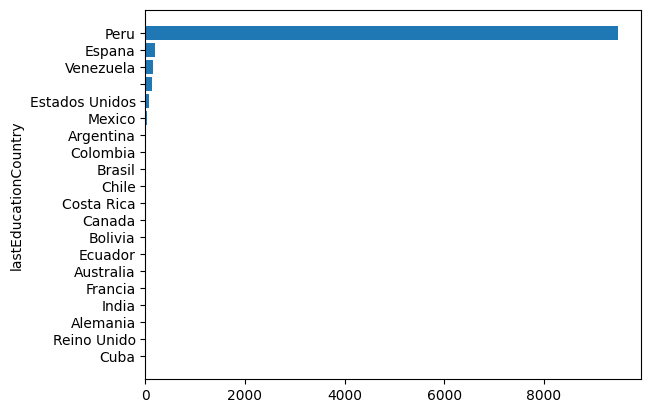

Ing. En Sistemas                  2308
Tecnologias De La Informacion     1237
Adm. De Empresas                  1134
Ing. Informatica                   616
Ing. Industrial                    489
Computacion / Informatica          478
Marketing / Comercializacion       367
Recursos Humanos / Relac. Ind.     354
Psicologia                         347
Otra                               341
                                   204
Ing. - Otros                       191
Trabajo Social                     143
Analisis De Sistemas               138
Ing. Telecomunicaciones            130
Programacion                       122
Telecomunicaciones                 118
Procesos / Calidad Total           104
Finanzas                            95
Bachiller                           91
Name: lastEducationArea, dtype: int64


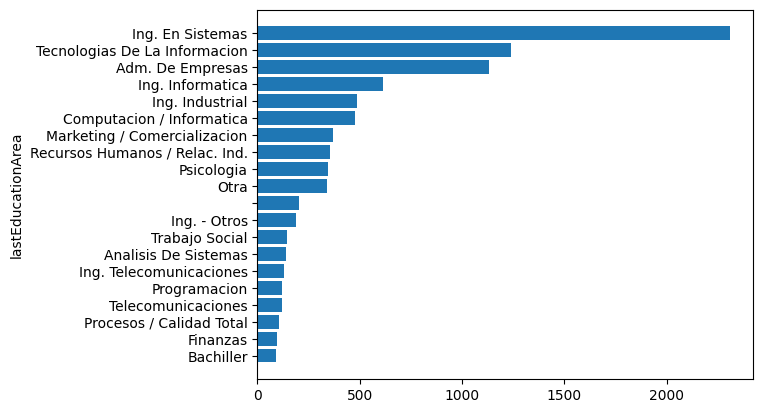

Ingenieria De Sistemas                       1590
Ingenieria Industrial                         335
Psicologia                                    307
Administracion De Empresas                    231
Computacion E Informatica                     181
                                              142
Mba                                           130
Bachiller En Ingenieria De Sistemas           129
Administracion                                126
Marketing                                     121
Administracion Y Negocios Internacionales      92
Ingles                                         84
Itil                                           75
Scrum Master                                   74
Gestion De Proyectos                           74
Trabajo Social                                 69
Ingenieria Informatica                         61
Ingenieria De Redes Y Comunicaciones           61
Ingenieria De Software                         55
Tecnico En Computacion E Informatica           54


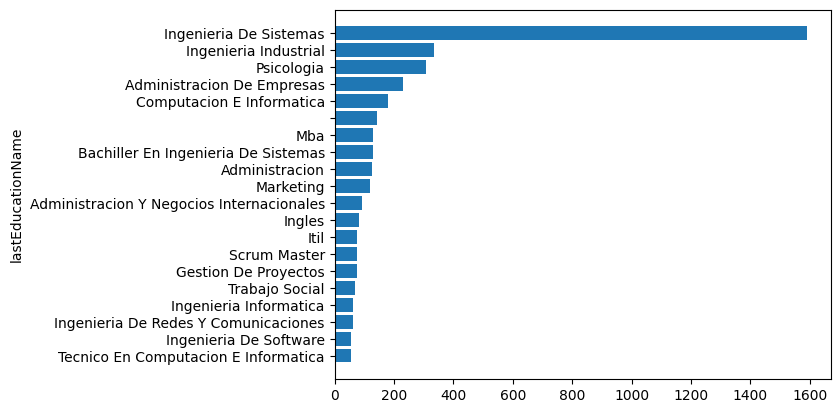

Graduado      6607
En Curso      3326
Abandonado     168
               124
Name: lastEducationStatus, dtype: int64


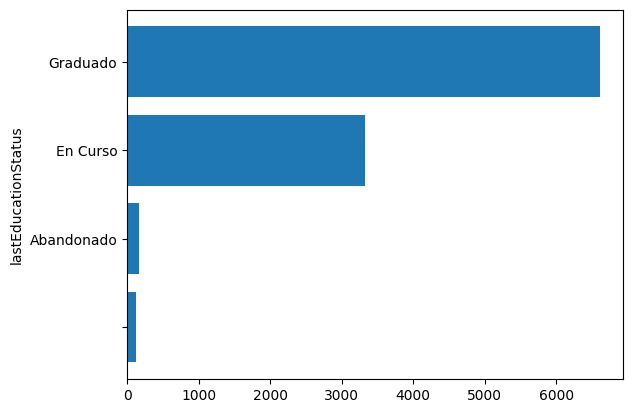

Universitario        5016
Otro                 2274
Posgrado             1176
Terciario/Tecnico    1010
Master                602
                      123
Doctorado              13
Secundario             11
Name: lastEducationDegree, dtype: int64


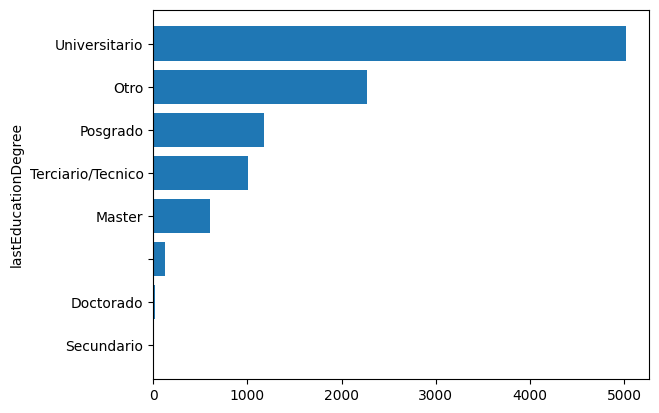

5     1671
6     1352
4     1342
7     1165
8      881
3      680
9      594
10     474
11     339
2      297
12     255
0      203
13     188
14     127
15     114
1       94
16      83
18      60
19      53
20      49
Name: yearsOfStudy, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


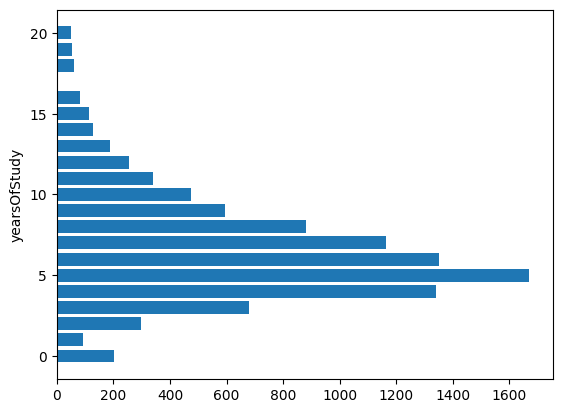

1     3820
2     2349
3     1166
4      711
5      471
6      427
7      283
8      191
9      142
0      123
11     117
10      90
12      69
14      53
13      44
16      25
15      22
20      19
18      18
17      17
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


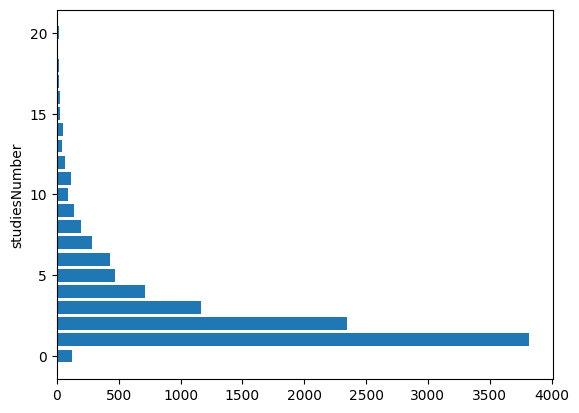

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


0     1220
1     1122
3      863
2      808
4      685
5      586
6      526
7      486
9      448
8      420
11     341
10     336
12     258
13     240
16     231
14     184
15     160
17     126
18     119
21      92
Name: technicalSkills, dtype: int64


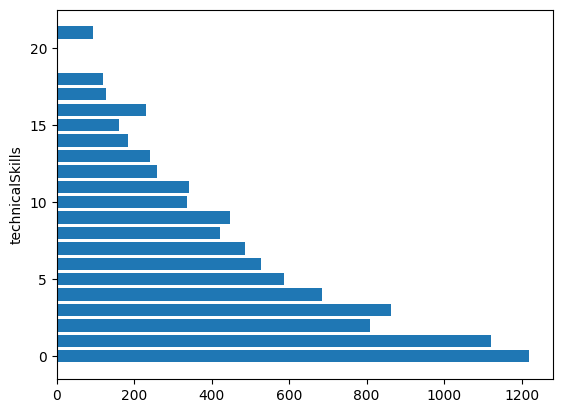

1    7122
2    1973
0     772
3     302
4      55
5       1
Name: languages, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


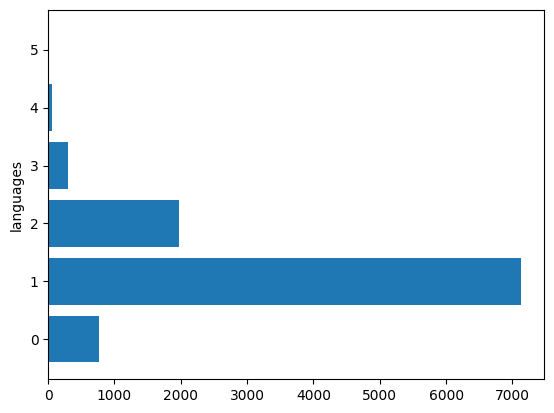

0     2372
1     1752
2     1171
3      835
4      743
5      635
6      494
7      430
8      342
9      274
10     215
11     174
12     139
13     115
14      89
15      69
17      50
16      49
20      36
19      32
Name: otherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3628\1818815522.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


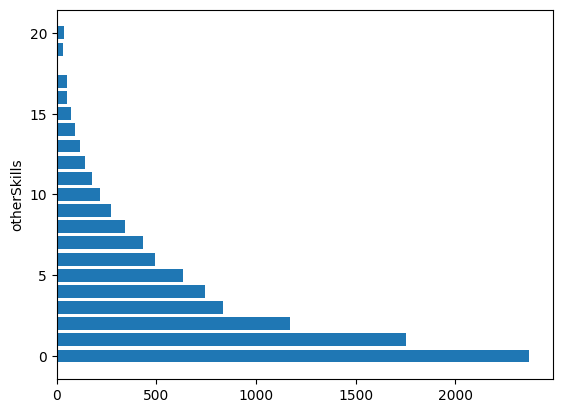

0    9722
1     503
Name: hired, dtype: int64


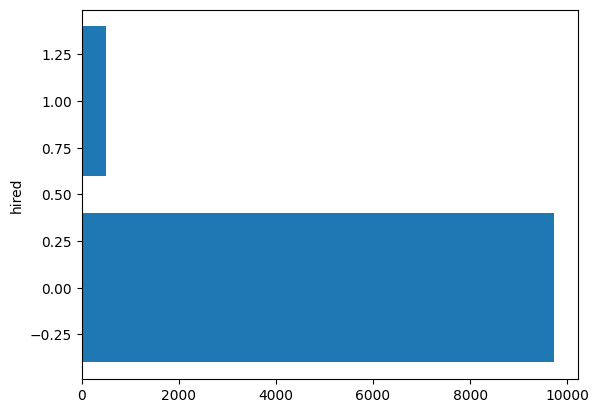

Fin: 2023-05-22 00:42:56.323676
Tiempo: 0:00:02.992004


In [21]:
if __name__ == "__main__":
  main()